# End-to-end example

In most of the examples we've had, the data is clean and simple, and the objective was well-defined. We have
often had a focus on just one step of the analysis or on one technique.

In this lesson, we are just going to start with a plan and work it through from there.

You have decided that the world would be better off if we had more bicycles and fewer cars, so you decide to investigate. You discover that the Divvy bike rental platform has recorded data on bicycle rentals in Chicago since 2013.

It is government-owned public data, so it's available. https://catalog.data.gov/dataset/divvy-trips

Here are some starting questions:

- How is Divvy doing? Is it growing? Is it shrinking? 

- If it weren't for the coronavirus, how many trips would we have expected for 2020?
  
- What factors predict bicycle usage?

In [4]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

In [7]:
import datetime

In [2]:
import pandas as pd

In [9]:
import scipy.stats

Often we have to deal with datasets that are very large. Pandas loads everything into memory, so for a multi-gigabyte
dataset such as the one from Divvy, this next cell will crash your computer.

In [ ]:
#divvy = pd.read_csv('\\Users\\gregb\\Downloads\\Divvy_Trips.csv')
#  Not enough memory!

Dask on the other hand, has a very similar interface to pandas, but can operate with on-disk data, and can also
paralellise over multiple CPUs.

In [3]:
import dask.dataframe

In [4]:
divvy = dask.dataframe.read_csv('\\Users\\gregb\\Downloads\\Divvy_Trips.csv')

In [5]:
divvy.columns

Index(['TRIP ID', 'START TIME', 'STOP TIME', 'BIKE ID', 'TRIP DURATION',
       'FROM STATION ID', 'FROM STATION NAME', 'TO STATION ID',
       'TO STATION NAME', 'USER TYPE', 'GENDER', 'BIRTH YEAR', 'FROM LATITUDE',
       'FROM LONGITUDE', 'FROM LOCATION', 'TO LATITUDE', 'TO LONGITUDE',
       'TO LOCATION'],
      dtype='object')

In [6]:
divvy.head(5)

,TRIP ID,START TIME,STOP TIME,BIKE ID,TRIP DURATION,FROM STATION ID,FROM STATION NAME,TO STATION ID,TO STATION NAME,USER TYPE,GENDER,BIRTH YEAR,FROM LATITUDE,FROM LONGITUDE,FROM LOCATION,TO LATITUDE,TO LONGITUDE,TO LOCATION
0,8546790,12/31/2015 05:35:00 PM,12/31/2015 05:44:00 PM,979,521,117,Wilton Ave & Belmont Ave,229,Southport Ave & Roscoe St,Subscriber,Female,1991.0,41.940180,-87.653040,POINT (-87.65304 41.94018),41.943739,-87.664020,POINT (-87.66402 41.943739)
1,8546793,12/31/2015 05:37:00 PM,12/31/2015 05:41:00 PM,1932,256,301,Clark St & Schiller St,138,Clybourn Ave & Division St,Subscriber,Male,1992.0,41.907993,-87.631501,POINT (-87.631501 41.907993),41.904613,-87.640552,POINT (-87.640552 41.904613)
2,8546795,12/31/2015 05:37:00 PM,12/31/2015 05:40:00 PM,1693,134,465,Marine Dr & Ainslie St,251,Clarendon Ave & Leland Ave,Subscriber,Female,1987.0,41.971600,-87.650154,POINT (-87.650154 41.9716),41.967968,-87.650001,POINT (-87.650001 41.967968)
3,8546797,12/31/2015 05:38:00 PM,12/31/2015 05:55:00 PM,3370,995,333,Ashland Ave & Blackhawk St,198,Green St (Halsted St) & Madison St,Subscriber,Male,1975.0,41.907066,-87.667252,POINT (-87.667252 41.907066),41.881892,-87.648789,POINT (-87.648789 41.881892)
4,8546798,12/31/2015 05:38:00 PM,12/31/2015 05:41:00 PM,2563,177,48,Larrabee St & Kingsbury St,111,Sedgwick St & Huron St,Subscriber,Male,1990.0,41.897764,-87.642884,POINT (-87.642884 41.897764),41.894666,-87.638437,POINT (-87.638437 41.894666)


In [7]:
divvy['start_date'] = divvy['START TIME'].str.split(' ').map(lambda x: x[0])

In [8]:
divvy.start_date.head(5)

0    12/31/2015
1    12/31/2015
2    12/31/2015
3    12/31/2015
4    12/31/2015
Name: start_date, dtype: object

In [10]:
trips_by_date = divvy.groupby('start_date')['TRIP ID'].count()

In [11]:
trips_by_date.head(1)

start_date
01/01/2014    123
Name: TRIP ID, dtype: int64

One small difference is that many dask computations (e.g. groupby) don't actually happen until you
trigger the compute step.

In [ ]:
trips_by_date.compute()

In [ ]:
trips_by_date.reset_index().to_csv('divvy_daily_trips.csv')

# Alternate starting point

Now that we have that summary calculated, we can work with pandas instead.

In [3]:
divvy_daily_trips = pd.read_csv('divvy_daily_trips.csv', parse_dates=['start_day'], index_col='start_day')

In [5]:
divvy_daily_trips.dtypes

Unnamed: 0    int64
TRIP ID       int64
dtype: object

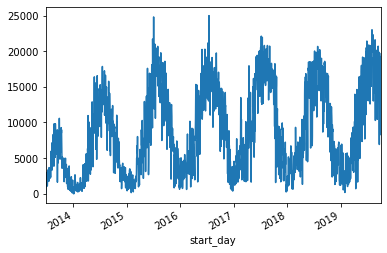

In [6]:
divvy_daily_trips['TRIP ID'].plot()

Was 2019 different to 2018?

In [8]:
divvy2018 = divvy_daily_trips[(divvy_daily_trips.index <= datetime.datetime(2018,9,30)) &
                              (divvy_daily_trips.index >= datetime.datetime(2018,1,1))
                             ]
divvy2019 = divvy_daily_trips['2019']
divvy2018.shape, divvy2019.shape

((273, 2), (273, 2))

In [10]:
scipy.stats.mannwhitneyu(divvy2018['TRIP ID'], divvy2019['TRIP ID'])

MannwhitneyuResult(statistic=34899.5, pvalue=0.09977345470694138)

The Mann-Whitney U-test -- https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test -- is an easy way to ask
whether two sets of numbers are equivalent. A p-value of 0.09977 (roughly 10%) means that even if they were
drawn from the same underlying distribution you would see this happen 10% of the time.

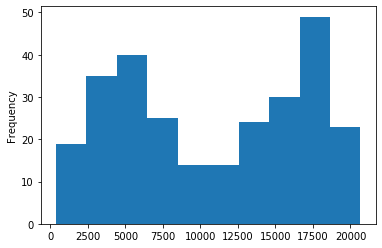

In [11]:
divvy2018['TRIP ID'].plot.hist()

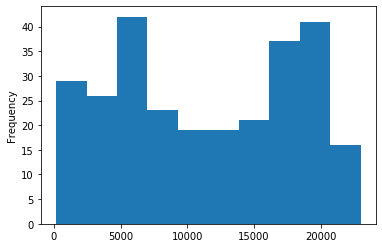

In [12]:
divvy2019['TRIP ID'].plot.hist()

What about comparing 2014 and 2018?

In [13]:
divvy2014 = divvy_daily_trips["2014"]['TRIP ID']
divvy2018 = divvy_daily_trips["2018"]['TRIP ID']
scipy.stats.mannwhitneyu(divvy2014, divvy2018)

MannwhitneyuResult(statistic=45494.5, pvalue=1.2896167594466918e-13)

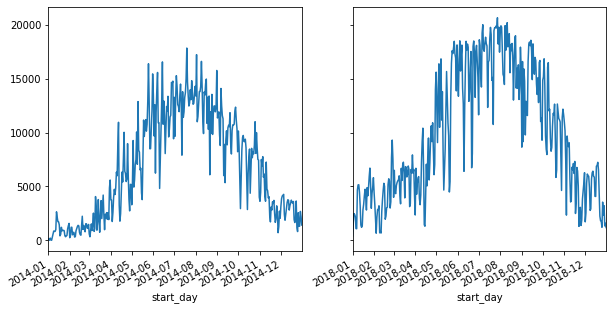

In [14]:
(fig, axes) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
divvy2014.plot(ax=axes[0])
divvy2018.plot(ax=axes[1])

In [15]:
divvy2014.mean()

6762.077134986226

In [16]:
divvy2018.mean()

9870.52602739726

# Timeseries decomposition

How much of this data is just random noise? How much can we explain?

Note that we use the `period=` which requires statsmodels version 0.11 or later.

In [17]:
import statsmodels

In [18]:
statsmodels.__version__

'0.11.1'

This is what to do if you are on an older version of statsmodels...

In [55]:
!pip install -U statsmodels

  Found existing installation: statsmodels 0.10.0
    Uninstalling statsmodels-0.10.0:
      Successfully uninstalled statsmodels-0.10.0


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'd:\\users\\gregb\\appdata\\local\\continuum\\anaconda3\\lib\\site-packages\\~tatsmodels\\nonparametric\\linbin.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



The autocorrelation and partial autocorrelation plots suggest that there is not much autocorrelation; there
is just a lot of correlation with external factors.

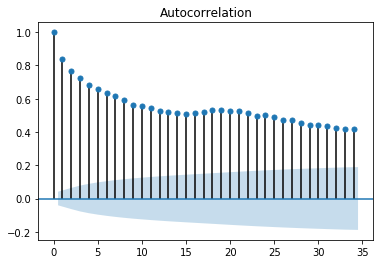

In [23]:
import statsmodels.graphics.tsaplots
statsmodels.graphics.tsaplots.plot_acf(divvy_daily_trips['TRIP ID']);

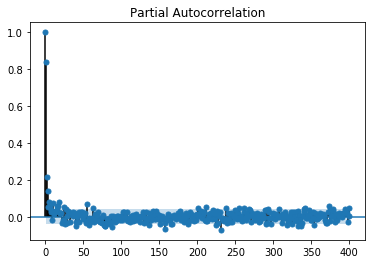

In [25]:
statsmodels.graphics.tsaplots.plot_pacf(divvy_daily_trips['TRIP ID'], lags=400);

Note what happens in the next cell. When you have a pandas series or dataframe that has a datetime index,
it also has a frequency (freq). It defaults to None.

In [28]:
import statsmodels.tsa.seasonal
statsmodels.tsa.seasonal.seasonal_decompose(divvy_daily_trips['TRIP ID'])

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

Notice that we are missing January 7th and 8th. Because there were no trips on these days, our
group by calculation doesn't have a row in the dataframe for these.

In [29]:
divvy_daily_trips['TRIP ID'].index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-09', '2014-01-10',
               '2014-01-11', '2014-01-12',
               ...
               '2019-09-21', '2019-09-22', '2019-09-23', '2019-09-24',
               '2019-09-25', '2019-09-26', '2019-09-28', '2019-09-29',
               '2019-09-30', '2019-09-27'],
              dtype='datetime64[ns]', name='start_day', length=2285, freq=None)

So we can't even force the frequency.

In [30]:
divvy_daily_trips['TRIP ID'].index.freq = '1D'

ValueError: Inferred frequency None from passed values does not conform to passed frequency D

In [32]:
divvy_daily_trips['TRIP ID'].resample('1D').median().index

DatetimeIndex(['2013-06-27', '2013-06-28', '2013-06-29', '2013-06-30',
               '2013-07-01', '2013-07-02', '2013-07-03', '2013-07-04',
               '2013-07-05', '2013-07-06',
               ...
               '2019-09-21', '2019-09-22', '2019-09-23', '2019-09-24',
               '2019-09-25', '2019-09-26', '2019-09-27', '2019-09-28',
               '2019-09-29', '2019-09-30'],
              dtype='datetime64[ns]', name='start_day', length=2287, freq='D')

Re-sampling partly solves the problem. It means that there is a NaN value for those dates, which we can fill with a zero.

In [35]:
trips = divvy_daily_trips['TRIP ID'].resample('1D').median().fillna(0)

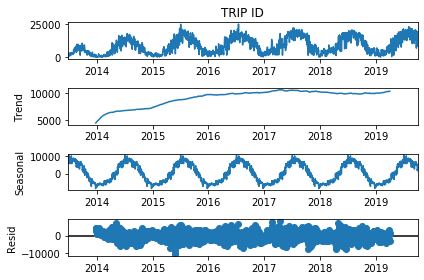

In [40]:
trips_season = statsmodels.tsa.seasonal.seasonal_decompose(trips, period=365)
trips_season.plot();

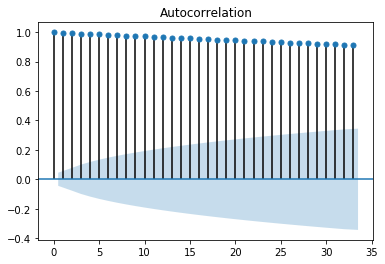

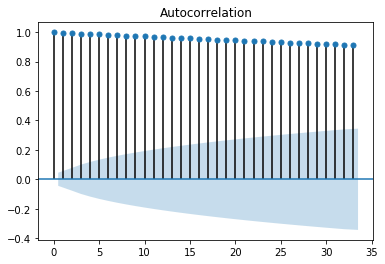

In [47]:
statsmodels.graphics.tsaplots.plot_acf(trips_season.trend[trips_season.trend.notnull()])

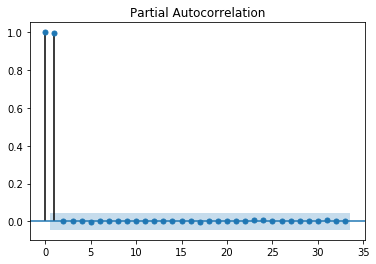

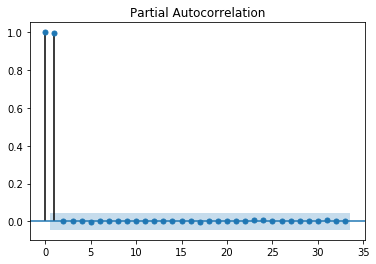

In [48]:
statsmodels.graphics.tsaplots.plot_pacf(trips_season.trend[trips_season.trend.notnull()])

In [43]:
trips_season.trend.autocorr()

0.9999765590040852

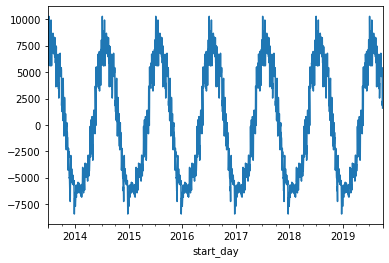

In [44]:
trips_season.seasonal.plot()

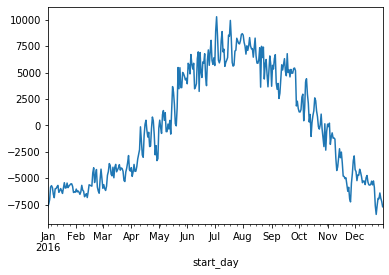

In [45]:
trips_season.seasonal["2016"].plot()

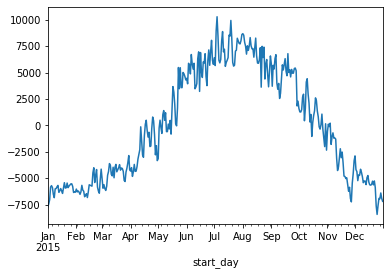

In [46]:
trips_season.seasonal["2015"].plot()

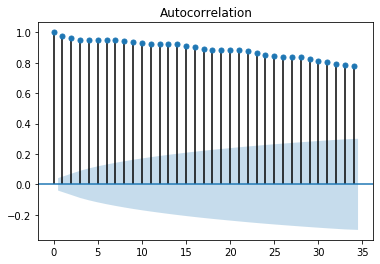

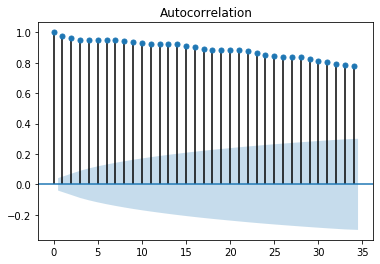

In [49]:
statsmodels.graphics.tsaplots.plot_acf(trips_season.seasonal[trips_season.seasonal.notnull()])

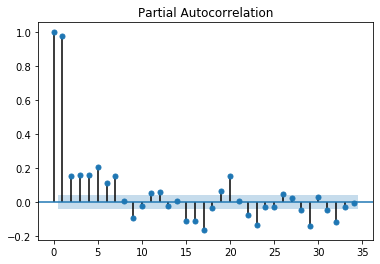

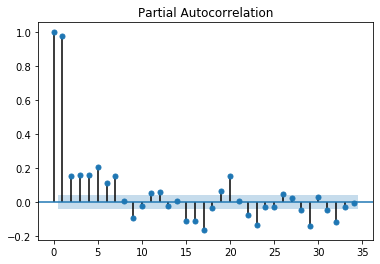

In [50]:
statsmodels.graphics.tsaplots.plot_pacf(trips_season.seasonal[trips_season.seasonal.notnull()])

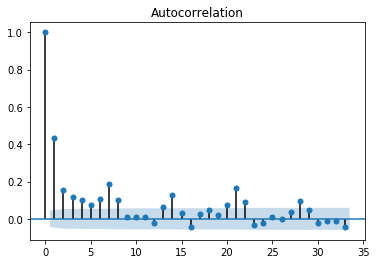

In [52]:
statsmodels.graphics.tsaplots.plot_acf(trips_season.resid[trips_season.resid.notnull()]);

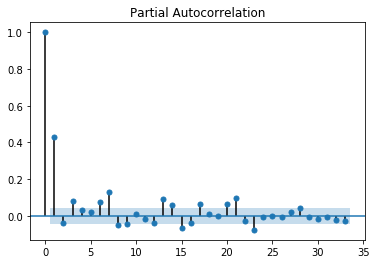

In [53]:
statsmodels.graphics.tsaplots.plot_pacf(trips_season.resid[trips_season.resid.notnull()]);

There is some autocorrelation -- it looks like about 40% of the number of trips each day is somehow related to the number of trips on the day before. But that's not particularly interesting on its own.

# Incorporating other data sources

We came up with a list of possible other factors:

- The weather
- The number of cars
- The number of cycling competitions and the prizes
- How many people made new years resolutions

Weather is easy to work with:

In [91]:
weather = pd.read_csv('2136141.csv', parse_dates=['DATE'], index_col='DATE')
weather = weather[weather.index.isin(trips.index)]
weather = weather[['AWND','PRCP' ,'SNOW' ,'SNWD' ,'TAVG' ,'TMAX' ,'TMIN']].copy()
weather.sample(5)

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
DATE,,,,,,,
2015-08-28,2.3,0.0,0.0,0.0,18.6,22.2,13.3
2016-12-09,4.4,0.0,0.0,0.0,-5.1,-3.8,-7.7
2016-06-01,2.9,10.7,0.0,0.0,20.1,26.1,16.7
2016-01-05,4.5,0.0,0.0,30.0,-3.6,0.6,-8.2
2019-04-10,8.0,3.3,0.0,0.0,4.7,3.9,1.1


In [92]:
trips[~trips.index.isin(weather.index)]

Series([], Freq: D, Name: TRIP ID, dtype: float64)

There are no missing days, so we can force the frequency.

In [93]:
weather.index.freq = '1D'

In [94]:
weather.index

DatetimeIndex(['2013-06-27', '2013-06-28', '2013-06-29', '2013-06-30',
               '2013-07-01', '2013-07-02', '2013-07-03', '2013-07-04',
               '2013-07-05', '2013-07-06',
               ...
               '2019-09-21', '2019-09-22', '2019-09-23', '2019-09-24',
               '2019-09-25', '2019-09-26', '2019-09-27', '2019-09-28',
               '2019-09-29', '2019-09-30'],
              dtype='datetime64[ns]', name='DATE', length=2287, freq='D')

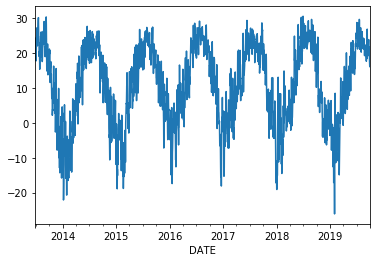

In [95]:
weather.TAVG.plot()

The thing we are trying to predict has had any seasonality taken out of it; so we want
to use seasonality-removed weather information to predict it. 

(In other words: how many of the extra bicycle hires were caused by unusually warms days for that time of year.)

In [98]:
weather_seasonal = {}
for col in ['AWND','PRCP' ,'SNOW' ,'SNWD' ,'TAVG' ,'TMAX' ,'TMIN']:
    temp = statsmodels.tsa.seasonal.seasonal_decompose(weather[col], period=365)
    #print(col)
    weather_seasonal[col] = temp.trend + temp.resid
    #print(temp.trend)
weather_df = pd.DataFrame(weather_seasonal)
weather_df = weather_df[weather_df['TAVG'].notnull()].copy()
weather_df.sample(5)

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
DATE,,,,,,,
2016-07-09,5.557537,2.879534,3.005271,14.749318,10.575110,12.688992,6.919674
2014-07-31,4.501263,2.878986,3.052395,14.705482,9.215494,15.786910,3.191400
2017-12-13,6.717098,0.225013,2.235956,9.894524,5.737960,12.210855,3.038962
2015-11-27,6.217866,18.026548,-23.164044,-24.105476,16.286179,22.782581,9.963400
2015-06-07,5.155181,9.268137,3.457326,16.243565,9.809741,15.422033,5.780112


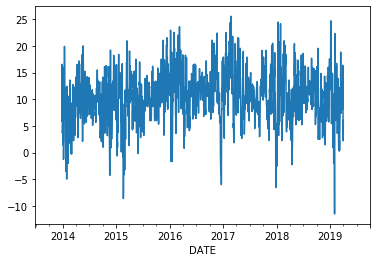

In [99]:
weather_seasonal['TAVG'].plot()

We can now create a data frame with the values we might want to try to predict and the weather information. We can use
various kinds of correlation.

In [101]:
df = weather_df.copy()
df['trips_delta'] = trips_season.resid + trips_season.trend
df['trips_resid'] = trips_season.resid
df

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,trips_delta,trips_resid
DATE,,,,,,,,,
2013-12-26,4.235062,1.538374,2.839335,23.512788,5.929129,12.459896,-0.537075,8398.741583,3982.067610
2013-12-27,3.018121,1.279424,3.339335,10.179455,10.246435,15.926335,4.330596,8514.105510,4057.524688
2013-12-28,4.567436,-6.170347,-4.660665,10.179455,16.530407,23.094554,10.780870,8860.936560,4366.985875
2013-12-29,4.533144,2.629790,0.006002,5.179455,13.899037,16.582454,1.515984,7033.068523,2501.923318
2013-12-30,3.331363,2.746456,2.339335,1.846122,3.618444,9.051677,-3.048901,7843.687702,3291.682222
2013-12-31,2.496706,9.182118,66.672669,27.679455,4.620818,8.105741,0.037217,7712.314642,3128.199574
2014-01-01,3.995701,4.548785,47.506002,69.346122,6.740681,10.877750,2.122834,7835.446149,3227.909163
2014-01-02,6.129948,7.465360,125.339335,130.179455,8.879037,11.766152,-1.390043,7553.992268,2913.400487
2014-01-03,6.713601,-0.079891,1.172669,171.846122,1.397850,11.233595,-8.670043,7047.591354,2373.226971


In [102]:
df.corr()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,trips_delta,trips_resid
AWND,1.000000,0.093132,0.053525,-0.030926,0.112826,0.016513,0.088715,-0.119376,-0.119979
PRCP,0.093132,1.000000,0.160986,0.008273,0.116534,0.044593,0.161976,-0.337858,-0.404435
SNOW,0.053525,0.160986,1.000000,0.255726,-0.108365,-0.139583,-0.124785,-0.150219,-0.103585
SNWD,-0.030926,0.008273,0.255726,1.000000,-0.367872,-0.303138,-0.400056,-0.221433,-0.062772
TAVG,0.112826,0.116534,-0.108365,-0.367872,1.000000,0.910903,0.915176,0.428038,0.352852
TMAX,0.016513,0.044593,-0.139583,-0.303138,0.910903,1.000000,0.788222,0.504284,0.466689
TMIN,0.088715,0.161976,-0.124785,-0.400056,0.915176,0.788222,1.000000,0.346888,0.237791
trips_delta,-0.119376,-0.337858,-0.150219,-0.221433,0.428038,0.504284,0.346888,1.000000,0.822557
trips_resid,-0.119979,-0.404435,-0.103585,-0.062772,0.352852,0.466689,0.237791,0.822557,1.000000


In [103]:
df.corr('spearman')

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,trips_delta,trips_resid
AWND,1.000000,0.124301,0.036503,0.006167,0.098765,-0.009361,0.093280,-0.121622,-0.122571
PRCP,0.124301,1.000000,0.125287,-0.038384,0.124959,0.036500,0.191299,-0.307436,-0.376187
SNOW,0.036503,0.125287,1.000000,0.494099,-0.174280,-0.179839,-0.170446,-0.133918,-0.111982
SNWD,0.006167,-0.038384,0.494099,1.000000,-0.300609,-0.251093,-0.316424,-0.218185,-0.061711
TAVG,0.098765,0.124959,-0.174280,-0.300609,1.000000,0.901838,0.897381,0.423230,0.341257
TMAX,-0.009361,0.036500,-0.179839,-0.251093,0.901838,1.000000,0.754780,0.485285,0.442219
TMIN,0.093280,0.191299,-0.170446,-0.316424,0.897381,0.754780,1.000000,0.334915,0.221439
trips_delta,-0.121622,-0.307436,-0.133918,-0.218185,0.423230,0.485285,0.334915,1.000000,0.778446
trips_resid,-0.122571,-0.376187,-0.111982,-0.061711,0.341257,0.442219,0.221439,0.778446,1.000000


In [104]:
df.corr('kendall')

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,trips_delta,trips_resid
AWND,1.000000,0.083142,0.025301,0.005058,0.066560,-0.006973,0.063032,-0.081027,-0.081563
PRCP,0.083142,1.000000,0.090231,-0.025130,0.082645,0.024545,0.125642,-0.209589,-0.259500
SNOW,0.025301,0.090231,1.000000,0.447046,-0.121103,-0.123153,-0.120117,-0.087968,-0.075066
SNWD,0.005058,-0.025130,0.447046,1.000000,-0.208805,-0.172430,-0.221487,-0.142130,-0.040693
TAVG,0.066560,0.082645,-0.121103,-0.208805,1.000000,0.728432,0.730371,0.287029,0.232440
TMAX,-0.006973,0.024545,-0.123153,-0.172430,0.728432,1.000000,0.564089,0.334025,0.306449
TMIN,0.063032,0.125642,-0.120117,-0.221487,0.730371,0.564089,1.000000,0.224400,0.148695
trips_delta,-0.081027,-0.209589,-0.087968,-0.142130,0.287029,0.334025,0.224400,1.000000,0.631102
trips_resid,-0.081563,-0.259500,-0.075066,-0.040693,0.232440,0.306449,0.148695,0.631102,1.000000


It's not often that you see Spearman and Pearson correlation numbers so similar. It's hard to express what 
this means: that most of these weather features are quite continuous and evenly spread out.

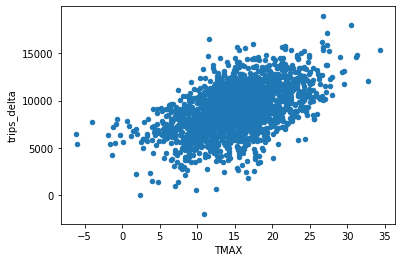

In [109]:
df.plot.scatter(x='TMAX', y='trips_delta')

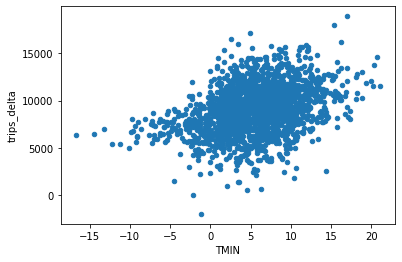

In [110]:
df.plot.scatter(x='TMIN', y='trips_delta')

There are two very good machine learning algorithms that we haven't otherwise touched on. 

- XGBoost
- Histogram Gradient Boosting

They are both similar to random forests: they are large networks of decision trees trained in generations based
on the outputs of the previous generation.

Histogram Gradient Boosting is part of the sklearn library (even though it is still experimental and requires
a special magic sequence to import it). The reason it is as fast as it is, is because it buckets each feature into
bins and thus reduces the number of splits it has to calculate for each decision tree.

XGBoost is a separate library which is a little difficult to install on OSX. You need to install Cmake first.

In [106]:
import xgboost

In [107]:
from sklearn.experimental import enable_hist_gradient_boosting

In [108]:
import sklearn.ensemble

In [ ]:
sklearn.ensemble.HistGradientBoostingRegressor

In [115]:
feature_columns = ['AWND' ,'PRCP' ,'SNOW' ,'SNWD' ,'TAVG' ,'TMAX' ,'TMIN']

In [120]:
sklearn.model_selection.cross_validate(
    xgboost.XGBRegressor(),
    df[feature_columns],
    df.trips_delta,
    cv=5,
    scoring='neg_median_absolute_error'
)['test_score'].mean()

-1675.5943544163813

Let's create a function that does cross validation and gives us a useful number that expresses how good that regressor is.

In [124]:
def test_regressor(regressor, feature_columns):
    return sklearn.model_selection.cross_validate(
        regressor,
        df[feature_columns],
        df.trips_delta,
        cv=5,
        scoring='neg_median_absolute_error'
    )['test_score'].mean()

In [125]:
test_regressor(xgboost.XGBRegressor(), feature_columns)

-1675.5943544163813

In [126]:
test_regressor(sklearn.ensemble.HistGradientBoostingRegressor(), feature_columns)

-1576.070447350247

In [127]:
import sklearn.dummy
test_regressor(sklearn.dummy.DummyRegressor(), feature_columns)

-1920.422970494655

In [129]:
test_regressor(sklearn.ensemble.RandomForestRegressor(n_estimators=50), feature_columns)

-1580.820046027397

If you have a lot of time, you can try to tune the hyperparameters of the Histogram Gradient Boosting regressor --
it is already doing better than any other algorithm, but maybe it can do better.

In [132]:
test_regressor(sklearn.model_selection.GridSearchCV(sklearn.ensemble.HistGradientBoostingRegressor(),
                                    param_grid={'learning_rate': [0.1, 0.2, 0.005],
                                               'max_depth': [None, 2, 3],
                                               'l2_regularization': [0.0, 0.1]}), feature_columns)

D:\Users\gregb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Users\gregb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Users\gregb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Users\gregb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning

KeyboardInterrupt: 

In [133]:
import sklearn.linear_model

In [137]:
test_regressor(sklearn.linear_model.HuberRegressor(), feature_columns)

-1582.5438635780388

In [140]:
test_regressor(sklearn.linear_model.RANSACRegressor(), feature_columns)

-1914.6270817388663

In [141]:
test_regressor(sklearn.linear_model.TheilSenRegressor(), feature_columns)

-1711.6066757596186

It's useful to create a dataframe of the results of different kinds of regressors. It makes it easier to compare.

In [153]:
%%time
scoring_df = pd.DataFrame({
    'regressor' : ['Huber', 'HistGrad', 'RandomForest'],
    'score': [test_regressor(x, feature_columns) for x in 
              [sklearn.linear_model.HuberRegressor(),
               sklearn.ensemble.HistGradientBoostingRegressor(),
              sklearn.ensemble.RandomForestRegressor(n_estimators=100)]
             ]
})
scoring_df

Wall time: 17.9 s


,regressor,score
0,Huber,-1582.543864
1,HistGrad,-1576.070447
2,RandomForest,-1571.170423


Do we need all those features? There are many ways of reducing the number of features in a model, many of
of which are available in `sklearn.feature_selection`

Here we just look at every combination of three features and see how well they do.

In [146]:
import itertools

In [156]:
for subset_of_columns in itertools.combinations(feature_columns, 3):
    print(subset_of_columns, test_regressor(sklearn.ensemble.HistGradientBoostingRegressor(), list(subset_of_columns)))

('AWND', 'PRCP', 'SNOW') -1850.7332311418947
('AWND', 'PRCP', 'SNWD') -1726.0037282166795
('AWND', 'PRCP', 'TAVG') -1637.114977149836
('AWND', 'PRCP', 'TMAX') -1692.097070529787
('AWND', 'PRCP', 'TMIN') -1674.1428243708083
('AWND', 'SNOW', 'SNWD') -1836.3826396763866
('AWND', 'SNOW', 'TAVG') -1710.923237953713
('AWND', 'SNOW', 'TMAX') -1726.617810971357
('AWND', 'SNOW', 'TMIN') -1714.391183582029
('AWND', 'SNWD', 'TAVG') -1658.1794723422784
('AWND', 'SNWD', 'TMAX') -1688.516743844916
('AWND', 'SNWD', 'TMIN') -1737.6338436027859
('AWND', 'TAVG', 'TMAX') -1727.185030660119
('AWND', 'TAVG', 'TMIN') -1749.9321722679983
('AWND', 'TMAX', 'TMIN') -1764.035118397201
('PRCP', 'SNOW', 'SNWD') -1790.6530353017538
('PRCP', 'SNOW', 'TAVG') -1595.987884950831
('PRCP', 'SNOW', 'TMAX') -1669.3407975456753
('PRCP', 'SNOW', 'TMIN') -1630.1472289299531
('PRCP', 'SNWD', 'TAVG') -1580.6153954684053
('PRCP', 'SNWD', 'TMAX') -1615.8776077586792
('PRCP', 'SNWD', 'TMIN') -1651.832019757742
('PRCP', 'TAVG', 'TM

PRCP (precipitation), SNWD (snow depth) and TAGV (average temperature) are nearly as good as using all weather data.

What else can we use? How about the previous day and the previous weeks cyclist counts?

In [163]:
df['yesterday_trips'] = df.trips_delta.shift(1)
df['last_weeks_trips'] = df.trips_delta.shift(7)
df = df[df.last_weeks_trips.notnull()]
df

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,trips_delta,trips_resid,yesterday_trips,last_weeks_trips
DATE,,,,,,,,,,,
2014-01-02,6.129948,7.465360,125.339335,130.179455,8.879037,11.766152,-1.390043,7553.992268,2913.400487,7835.446149,8398.741583
2014-01-03,6.713601,-0.079891,1.172669,171.846122,1.397850,11.233595,-8.670043,7047.591354,2373.226971,7553.992268,8514.105510
2014-01-04,5.230952,7.803442,56.839335,150.179455,8.815567,14.751540,7.499135,6050.975373,1344.178112,7047.591354,8860.936560
2014-01-05,6.314605,14.725543,179.839335,188.512788,11.633741,17.503595,-0.715477,5746.667610,1013.563501,6050.975373,7033.068523
2014-01-06,7.315792,2.808876,2.506002,221.846122,-1.299456,2.835650,-6.599586,5894.023775,1133.385418,5746.667610,7843.687702
2014-01-07,4.000222,2.803077,3.339335,200.179455,-1.084890,5.983367,-5.234427,6534.813729,1744.484962,5894.023775,7712.314642
2014-01-08,1.150085,-0.196923,-9.327331,206.012788,1.962873,7.766198,-4.321048,6854.857565,2031.789071,6534.813729,7835.446149
2014-01-09,1.799856,1.953077,2.839335,180.179455,1.977759,13.483641,-3.805659,6878.302770,2020.705510,6854.857565,7553.992268
2014-01-10,3.667162,19.686548,2.506002,185.179455,14.980453,20.470262,12.363793,6811.679939,1925.605966,6878.302770,7047.591354


In [165]:
test_regressor(sklearn.linear_model.HuberRegressor(),
              ['AWND', 'SNWD', 'TAVG', 'yesterday_trips', 'last_weeks_trips'])

-1102.712379980455

That's a big improvement. What if we include the price of petrol as well?

There are two challenges here.

1. The petrol price is given in a spreadsheet that has months as columns. We want to melt this dataframe
into a long narrow form.

2. It's only monthly data, so we need to interpolate it to make it daily.

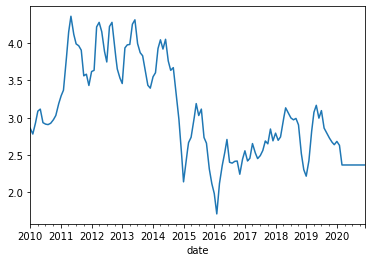

In [189]:
petrol_spreadsheet = pd.read_excel('SeriesReport-20200505193721_64241c.xlsx', skiprows=9).melt(
    id_vars=['Year'], var_name='Month', value_name='petrol_price')
petrol_spreadsheet['synthetic_date'] = petrol_spreadsheet.Year.map(str) + "-" + petrol_spreadsheet.Month + "-1"
petrol_spreadsheet['date'] = pd.to_datetime(petrol_spreadsheet['synthetic_date'])
petrol_spreadsheet.set_index('date', inplace=True)
petrol_spreadsheet.sort_index(inplace=True)
petrol_by_day = petrol_spreadsheet.petrol_price.resample('1D').median()
petrol_by_day = petrol_by_day.interpolate()
petrol_by_day.plot()

In [190]:
df['petrol_price'] = petrol_by_day
df.corr()

D:\Users\gregb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,trips_delta,trips_resid,yesterday_trips,last_weeks_trips,petrol_price
AWND,1.000000,0.093901,0.057017,-0.030698,0.111403,0.014964,0.087136,-0.120272,-0.118096,0.001177,0.073620,0.033617
PRCP,0.093901,1.000000,0.159527,0.007910,0.118324,0.046470,0.163684,-0.338073,-0.405696,-0.022456,0.025515,0.003373
SNOW,0.057017,0.159527,1.000000,0.254856,-0.105175,-0.136296,-0.122190,-0.149422,-0.109062,-0.085723,-0.038641,0.075027
SNWD,-0.030698,0.007910,0.254856,1.000000,-0.368006,-0.303043,-0.400702,-0.221356,-0.063993,-0.236506,-0.139629,0.219107
TAVG,0.111403,0.118324,-0.105175,-0.368006,1.000000,0.910728,0.915581,0.428332,0.357082,0.452412,0.133152,-0.200045
TMAX,0.014964,0.046470,-0.136296,-0.303043,0.910728,1.000000,0.788076,0.504594,0.470903,0.404838,0.104208,-0.162959
TMIN,0.087136,0.163684,-0.122190,-0.400702,0.915581,0.788076,1.000000,0.346270,0.243285,0.374751,0.144933,-0.222710
trips_delta,-0.120272,-0.338073,-0.149422,-0.221356,0.428332,0.504594,0.346270,1.000000,0.829173,0.577637,0.399393,-0.376112
trips_resid,-0.118096,-0.405696,-0.109062,-0.063993,0.357082,0.470903,0.243285,0.829173,1.000000,0.337871,0.132110,0.015501
yesterday_trips,0.001177,-0.022456,-0.085723,-0.236506,0.452412,0.404838,0.374751,0.577637,0.337871,1.000000,0.338841,-0.375816


## Other dimensionality reduction options

There are other ways of having fewer features. Principal Component Analysis is a famous one. T-SNEF and UMAP are 
less famous, but produce very interesting results by allowing a little bit of randomness and a little bit of warping
of the distances between distant points.


In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()

In [194]:
scaler = sklearn.preprocessing.RobustScaler()
scaled_weather = scaler.fit_transform(df[['AWND','PRCP','SNOW','SNWD','TAVG','TMAX','TMIN']])

In [ ]:
weather2d = reducer.fit_transform()